# Structure of notebook
 > Basic prophet model on top 50 zipcodes <br>
 > How we chose the top 5 <br>
 > Optimize Parameters for 5 top Zipcodes Using Grid<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from numpy import load

In [3]:
# dropping columns that arent needed and using data from 2010 and above 
df = pd.read_csv('../../src/data/zillow_data_lf.csv')
df.time = pd.to_datetime(df.time)
df.drop(['RegionID','SizeRank'], axis = 1, inplace = True)
df = df[pd.DatetimeIndex(df['time']).year >2009]
df.head()

,RegionName,City,State,Metro,CountyName,time,value
2284438,60657,Chicago,IL,Chicago,Cook,2010-01-01,775600.0
2284439,75070,McKinney,TX,Dallas-Fort Worth,Collin,2010-01-01,201300.0
2284440,77494,Katy,TX,Houston,Harris,2010-01-01,249200.0
2284441,60614,Chicago,IL,Chicago,Cook,2010-01-01,984100.0
2284442,79936,El Paso,TX,El Paso,El Paso,2010-01-01,117400.0


# Modeling with prophet

In [4]:
def Prophet_func2(df, zipcodes, period, size_train):
    
    df_info = pd.DataFrame(dict(Zipcode=[], 
                                 Home_Value=[], 
                                 Future_Home_Value=[], 
                                 Percent_Increase=[],
                                 RMSE = [],
                                 MAPE =[])) 
    for zipcode in zipcodes:
        
       # selecting zipcode from df and changing time and value to ds and y
        data= df[df['RegionName']== zipcode]
        data = data[['time', 'value']]
        data.columns = ['ds','y']
        
        # creating stop index
        eotindex = round(data.shape[0] * size_train)
        train = data[:eotindex]
        test = data[eotindex:]
        
        train_size = train.shape[0]
        test_size = test.shape[0]
        freq = 'MS'
        
        value_now = int(data.y.tail(1))

        # Prophet Func
        model = Prophet(daily_seasonality= False, weekly_seasonality= False, interval_width=0.95)
        model.fit(train)
        future = model.make_future_dataframe(periods = period + test_size, freq = freq)
        forecast = model.predict(future)

        value_future = round(list(forecast.yhat)[-1],-2)
        diff= value_future - value_now
        rate_5_yrs = 100*(diff / value_now)
        
        y_hat = forecast.yhat[train_size:test_size+train_size]
        root_mse = round(np.sqrt(mean_squared_error(test.y,y_hat)),2)
        mean_ape = round(np.mean(np.abs((np.array(test.y) -  
                           np.array(y_hat))/ np.array(test.y))) * 100, 2)
        df_info = df_info.append({'Percent_Increase': rate_5_yrs,
                                  'Home_Value': value_now, 
                                  'Future_Home_Value': value_future,
                                  'Zipcode': zipcode,
                                  'RMSE': root_mse,
                                  'MAPE':mean_ape}, ignore_index = True)
                                    
        
        df_info.Zipcode = df_info.Zipcode.astype('int64')
    return df_info

In [5]:
zipcodes = load('../../src/data/zip_data.npy')
period = 60
size_train = .8

df_zipcodes = Prophet_func2(df, zipcodes, period, size_train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [6]:
df_zipcodes.sort_values(by=['MAPE']).reset_index(drop=True).head(10)

,Zipcode,Home_Value,Future_Home_Value,Percent_Increase,RMSE,MAPE
0,37221,344000.0,472800.0,37.441860,1633.23,0.39
1,37115,189800.0,300200.0,58.166491,868.40,0.40
2,37217,213000.0,329700.0,54.788732,1167.60,0.51
3,37013,211900.0,312800.0,47.616800,1724.82,0.75
4,37143,228100.0,302500.0,32.617273,2406.27,0.78
5,37148,157400.0,238900.0,51.778907,1421.32,0.81
6,37069,468100.0,592000.0,26.468703,5360.80,0.98
7,37137,34400.0,41300.0,20.058140,408.45,1.03
8,37122,310900.0,420200.0,35.155999,3602.90,1.06
9,37027,586800.0,737700.0,25.715746,7811.66,1.11


# Choosing Area Codes

We wanted to narrow down all the zipcodes in Nashville by running a basic prophet model on it and seeing how well the model was by mean absolute percentage error as well as what that model will predict for the housing increase. From above it looked like are codes 37115, 37217, 37013, 37148, 37221 all have high growth and low mean absolute error which is what we want.

# Optimizing Prophet

In [30]:
def optimized_params(df, zipcode, size_train):

    model_parameters = pd.DataFrame(columns = ['RMSE','MAPE','Parameters'])
    
    params_grid = {'seasonality_mode':('multiplicative','additive'),
                   'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
                   'n_changepoints' : [5,10,20,30]}
    grid = ParameterGrid(params_grid)
    
    data= df[df['RegionName']== zipcode]
    data = data[['time', 'value']]
    data.columns = ['ds','y']

    eotindex = round(data.shape[0] * size_train)
    train = data[:eotindex]
    test = data[eotindex:]

    train_size = train.shape[0]
    test_size = test.shape[0]
    freq = 'MS'
    period = 60

    for p in grid:
    
        # Prophet Func
        model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                             n_changepoints = p['n_changepoints'],
                             seasonality_mode = p['seasonality_mode'],
                             weekly_seasonality=False,
                             daily_seasonality = False,
                             yearly_seasonality = True,
                             interval_width=0.95)
        model.fit(train)
        future = model.make_future_dataframe(periods = period + test_size, freq = freq)
        forecast = model.predict(future)
        
        y_hat =  forecast.yhat[train_size:test_size+train_size]
        mean_ape = np.mean(np.abs((np.array(test.y) -  
                           np.array(y_hat))/ np.array(test.y))) * 100 #mean absolute percentage error 
        root_mse = np.sqrt(mean_squared_error(test.y,y_hat))


        model_parameters = model_parameters.append({'RMSE':root_mse,'Parameters':p, 'MAPE':mean_ape},ignore_index=True)
        
    param_dic = model_parameters.sort_values(by=['RMSE']).reset_index(drop=True)['Parameters'][0]
    return param_dic, model_parameters

In [31]:
best_zipcodes = [37115, 37217, 37013, 37148, 37221]
for zipcode in best_zipcodes:
    #param_zipcode, df_zipcode = function that returns the best parameters in terms of lowest RMSE and a data frame of all the iteration of parameters
    locals()['param_'+str(zipcode)], locals()['df_'+str(zipcode)] = optimized_params(df, zipcode, .75)

# Visualizations of Model Using Optimized Params

In [32]:
def plot_function(df, zipcode, params, size_test):

    data= df[df['RegionName']== zipcode]
    data = data[['time', 'value']]
    data.columns = ['ds','y']
    data.reset_index(inplace = True)

    eotindex = round(data.shape[0] * size_test)
    train = data[:eotindex]
    test = data[eotindex:]

    train_size = train.shape[0]
    test_size = test.shape[0]
    freq = 'MS'
    period = 60

    model = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                             n_changepoints = params['n_changepoints'],
                             seasonality_mode = params['seasonality_mode'],
                             weekly_seasonality=False,
                             daily_seasonality = False,
                             yearly_seasonality = True,
                             interval_width=0.60)
    model.fit(train)

    future = model.make_future_dataframe(periods = period + test_size, freq = freq)
    forecast = model.predict(future)

    y_hat =  forecast.yhat[train_size:test_size+train_size]
    MAPE = np.mean(np.abs((np.array(test.y) -  
                               np.array(y_hat))/ np.array(test.y))) * 100 
    root_mse = np.sqrt(mean_squared_error(test.y,y_hat))




    pd.plotting.register_matplotlib_converters()
    f, ax = plt.subplots(figsize=(14,5))
    train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
    test.plot(kind='line', x='ds', y='y', color='black', label='Test', ax=ax)
    forecast.loc[train_size:].plot(kind='line', x='ds', y='yhat', color='red', label='Predicted', ax=ax)
    plt.xlabel('Year')
    plt.ylabel('Home Value')
    plt.title(f'ZIP code {zipcode} Model Predictions')
    plt.show()

    return model, forecast

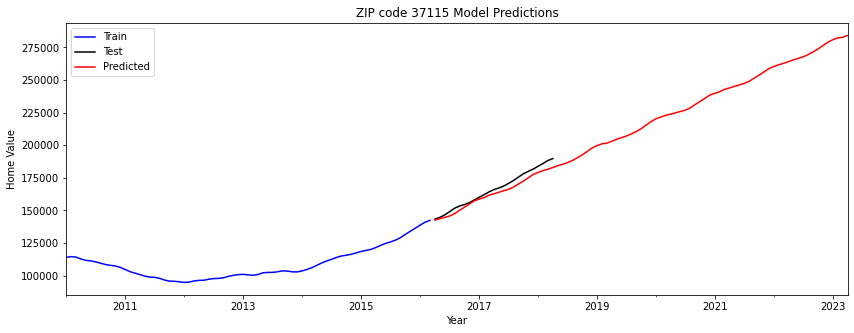

In [33]:
model_37115, forcast_37115 = plot_function(df,37115, param_37115, .75)

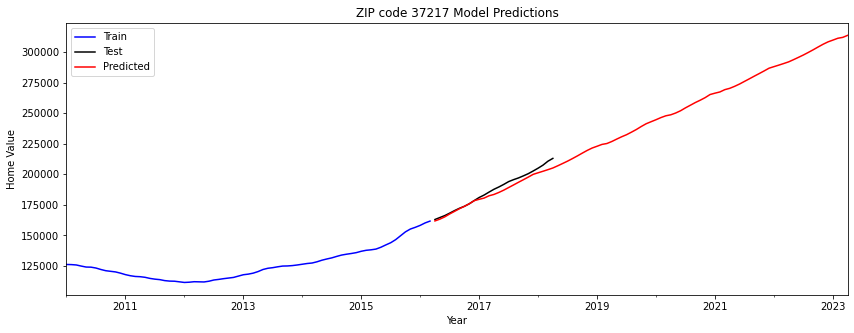

In [34]:
model_37217, forcast_37217 = plot_function(df,37217, param_37217, .75)

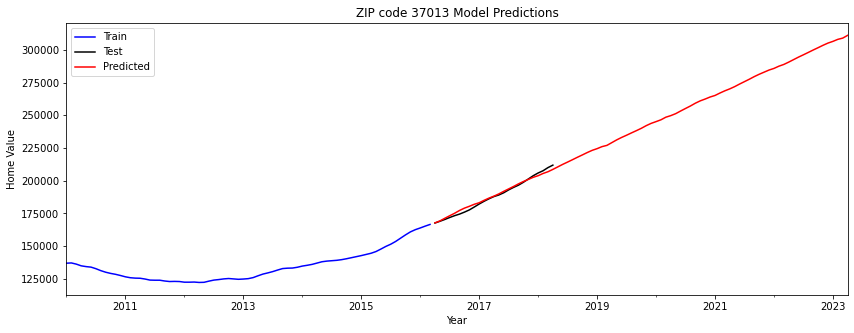

In [35]:
model_37013, forcast_37013 = plot_function(df,37013, param_37013, .75)

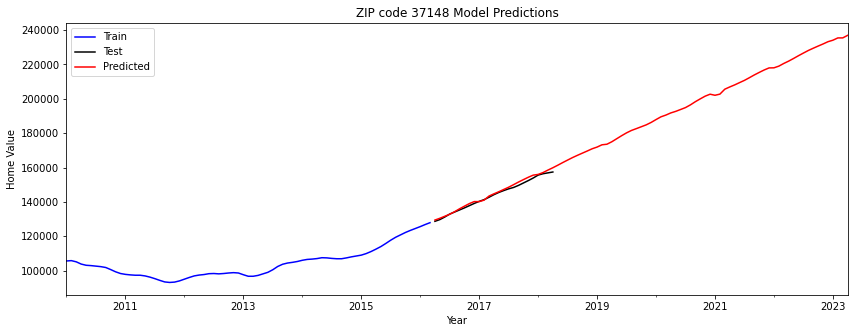

In [36]:
model_37148, forcast_37148 = plot_function(df,37148, param_37148, .75)

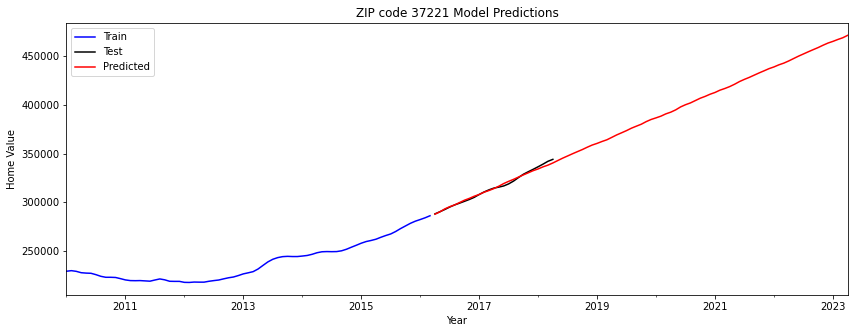

In [37]:
model_37221, forcast_37221 = plot_function(df,37221, param_37221, .75)